# Association

Modelling the explicit labelling of observations from different population components.

Model definition and simulation is done using pyStan with code in the `stan/` directory.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pystan
import stan_utility

In [2]:
# for nice plots when shown on GitHub nb viewer
import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')

## A simple mixture model

Consider observations drawn from a mixture of 2 gaussian distributions with different means and the same standard deviation. Each population has an associated weight, $w$, the set of which forms a 2-simplex. The model can be parameterised with a latent categorical variable or *label*, $\lambda$:

$$
\lambda \sim Categorical(w) 
$$

The observation $y_n$ is distributed according to which mixture componenet it is generated from.

$$
y_k \sim Normal(\mu_k, \sigma^2)   
$$
    
In order to treat this model in Stan, we marginalise over the discrete parameter:

$$
p(y \ | \ w, \mu, \sigma) = \sum_{k = 1}^2 w_k Normal( y \ | \ \mu_k, \sigma^2)
$$
    
  

In [3]:
# compile the stan simulation
simu_file = 'stan/simple_mixture_sim.stan'
simulation = stan_utility.compile_model(filename = simu_file)

Using cached StanModel


/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


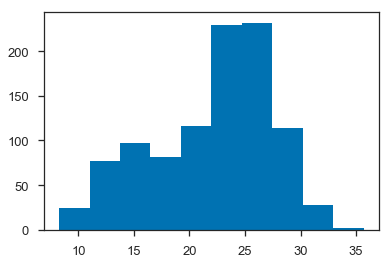

In [4]:
# Use stan to simulate draws from this mixutre model
simu_parameters = {'mu' : [15, 25],
                   'sigma' : 3, 
                   'w' : [0.3, 0.7], 
                   'N_obs' : 1000}

simu = simulation.sampling(data = simu_parameters, algorithm = "Fixed_param", 
                     iter = 1, chains = 1, seed = 19920715)

# plot the simulation
y_simu = simu.extract(['y'])['y'][0]
plt.hist(y_simu);

# dump the simulated data to a file
simu_data = {'N_obs' : len(y_simu), 'y' : y_simu}
data_file = 'data/simple_mixture.data.R'
pystan.stan_rdump(simu_data, data_file)

In [5]:
# compile the stan model
model_file = 'stan/simple_mixture.stan'
model = stan_utility.compile_model(filename = model_file)

Using cached StanModel


In [6]:
# fit the stan model
data = pystan.read_rdump(data_file)

fit = model.sampling(data = data, iter = 1000, chains = 4, seed = 19920715)
print(fit)

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_72b8af4e8332afb48865a8b41b83c449.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w[0]    0.28  4.6e-4   0.02   0.25   0.27   0.28   0.29   0.31   1326    1.0
w[1]    0.72  4.6e-4   0.02   0.69   0.71   0.72   0.73   0.75   1326    1.0
mu[0]  14.97  6.5e-3   0.22  14.53  14.82  14.96  15.12  15.42   1203    1.0
mu[1]  24.88  2.9e-3   0.13  24.63  24.79  24.88  24.97  25.14   2000    1.0
sigma    3.0  2.1e-3   0.08   2.85   2.95    3.0   3.05   3.16   1466    1.0
lp__   -2997    0.05   1.37  -3000  -2997  -2996  -2996  -2995    781    1.0

Samples were drawn using NUTS at Fri Jun 22 11:38:29 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


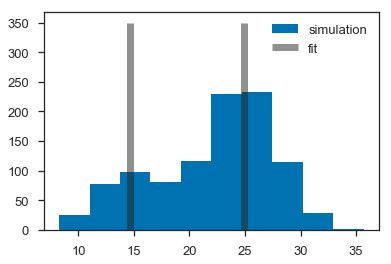

In [7]:
# plot the fit mu onto the simulated data
mu = fit.extract(['mu'])['mu'][0]
plt.hist(y_simu, label = 'simulation');
plt.vlines([mu[0], mu[1]], 0, 350, 
           linewidth = 7, alpha = 0.5, label = 'fit')
plt.legend()

## Explicit modelling of the association

In more physical applications, we want to know the rigorous probability for the association of an observation $y_i$ with a population component $k$. In order to do this, we basically want the marginal posterior for $\lambda$.

There are two things we can do in Stan to provide some useful information on this probability. 

* Save the values of the log probability `lp[i, k]` which correspsonds to $p(\lambda, y | \mu, \sigma)$. These can be marginalised to give $p(\lambda | \mu, \sigma, y)$
* Generate discrete samples based on `lp[i, k]` using a categorical RNG.

In [8]:
# compile a new model for the problem
explicit_model_file = 'stan/simple_mixture_explicit.stan'
explicit_model = stan_utility.compile_model(filename = explicit_model_file)

Using cached StanModel


In [9]:
# fit this model
explicit_fit = explicit_model.sampling(data = data, iter = 1000, 
                                       chains = 4, seed = 19920715)

# avoid printing the fit, as now mnay parameters
#print(explicit_fit)
ex = explicit_fit.extract(permuted = False)

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


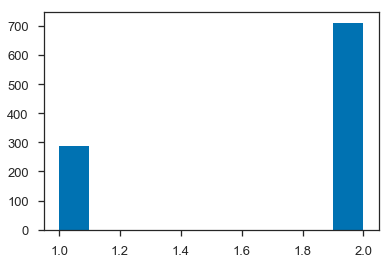

In [10]:
# plot the sampled labels (bit boring as we only have 2 components)
lam = explicit_fit.extract(['lambda'])['lambda'][0]
plt.hist(lam);

### Probability that observation $i$ comes from component $k$

For each observation $y_i$, the value of the log probability `lp[i, k]` is the log of $p(\lambda = k, y_i | \mu, \sigma)$. Averaging over the posterior draws gives $q(\lambda = k | y_i, \mu, \sigma)$, which can be normalised to give the final result:

$$
p(\lambda = k | y_i, \mu, \sigma) = \frac{q(\lambda = k | y_i, \mu, \sigma)}{\sum_l q(\lambda = l | y_i, \mu, \sigma)}
$$

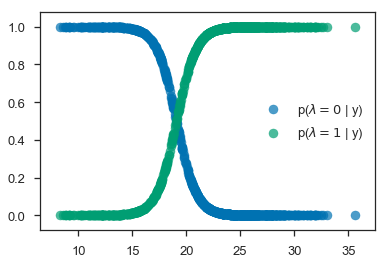

In [11]:
# answer: what is the probability that observation i comes from component k?

# find relevant starting index to extract
i_y0_l0 = 5 
i_y0_l1 = 5 + 1000

# find normalised marginal probability 
# associated with each observation
lp_l0 = []
lp_l1 = []
prob_l0 = []
prob_l1 = []
for i in range(len(y_simu)):
    # extract all iterations for all chains
    lp_i_l0 = np.transpose(ex)[i_y0_l0 + i][:][:].flatten()
    lp_i_l1 = np.transpose(ex)[i_y0_l1 + i][:][:].flatten()
    # exponentiate and average
    lp_l0.append(np.mean(np.exp(lp_i_l0)))
    lp_l1.append(np.mean(np.exp(lp_i_l1)))
    # normalise
    norm = (lp_l0[i] + lp_l1[i])
    prob_l0.append(lp_l0[i] / norm)
    prob_l1.append(lp_l1[i] / norm)

# plot the probabilities for different values of y_i
plt.scatter(y_simu, prob_l0, alpha = 0.7, label = 'p($\lambda = 0$ | y)')
plt.scatter(y_simu, prob_l1, alpha = 0.7, label = 'p($\lambda = 1$ | y)')
plt.legend()